In [1]:
# load the packages needed
import numpy as np

import sys
if "../" not in sys.path:
    sys.path.append("../")
from tsap.solver import Solver
from tsap.model import AR, MA
from tsap.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array

import tsap.data_processor as dp
from tsap.ts_gen import ar1_gen


import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


SyntaxError: Missing parentheses in call to 'print' (solver.py, line 79)

In [10]:
data = np.loadtxt("../data/SP500array.csv", delimiter=',')
X = np.array([data[0:100,0]])
Y = dp.get_return(X)



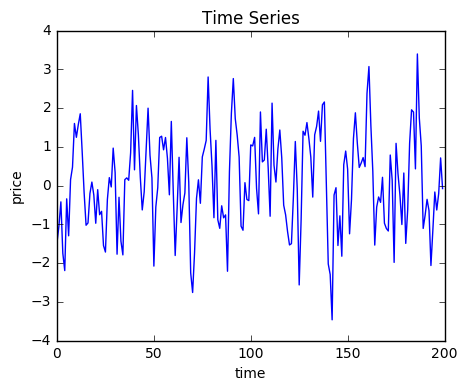

In [11]:
# generate a fake time series
from tsap.ts_gen import ar1_gen
Y = ar1_gen(0.5, sigma = 1.0, time = 200, num = 1, burnin = 2000)
plt.plot(Y.T)
plt.xlabel('time')
plt.ylabel('price')
plt.title('Time Series')
plt.show()

In [12]:
lag = 1
sigma = 2.0
intercept = 0.1
phi = np.random.randn(1, 1)
AR_model = AR(lag=lag, phi=phi, sigma=sigma, intercept=intercept)
AR_model.params

{'intercept': 0.1, 'phi': array([[ 0.70642177]]), 'sigma': 2.0}

In [13]:
_, grads = AR_model.loss(Y)


# define a useful mathod for future use
def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))


d_phi = grads['phi']
d_intercept = grads['intercept']

d_sigma = grads['sigma']

d_phi_num = eval_numerical_gradient_array(lambda phi: AR_model.loss(Y, lag,phi,sigma,intercept)[0], phi, 1)
print 'd_phi error: ', rel_error(d_phi_num, d_phi)

d_intercept_num = eval_numerical_gradient_array(lambda intercept: AR_model.loss(Y, lag,phi,sigma,intercept)[0], intercept, 1)
print 'd_intercept error: ', rel_error(d_intercept_num, d_intercept)

d_sigma_num = eval_numerical_gradient_array(lambda sigma: AR_model.loss(Y, lag,phi,sigma,intercept)[0], sigma, 1)
print 'd_sigma error: ', rel_error(d_sigma_num, d_sigma)

d_phi error:  3.21703883805e-11
d_intercept error:  3.8104342565e-10
d_sigma error:  3.24711416059e-12


In [14]:

solver = Solver(AR_model, Y,
                          update_rule='sgd',
                          optim_config={
                            'learning_rate': 1e-5,
                          },
                          
                          num_epochs=3000, batch_size=1,
                          print_every=100)
solver.train()
AR_model.params

3000
the loss is 344.156759
the loss is 338.811884
the loss is 333.434119
the loss is 328.072570
the loss is 322.791469
the loss is 317.671502
the loss is 312.809043
the loss is 308.311667
the loss is 304.288330
the loss is 300.833726
the loss is 298.009088
the loss is 295.825497
the loss is 294.237834
the loss is 293.154445
the loss is 292.459592
the loss is 292.038647
the loss is 291.795976
the loss is 291.661685
the loss is 291.589721
the loss is 291.552078
the loss is 291.532728
the loss is 291.522899
the loss is 291.517942
the loss is 291.515452
the loss is 291.514203
the loss is 291.513575
the loss is 291.513258
the loss is 291.513097
the loss is 291.513014
the loss is 291.512971


{'intercept': array([ 0.05119184]),
 'phi': array([[ 0.52980592]]),
 'sigma': array([ 1.04740643])}

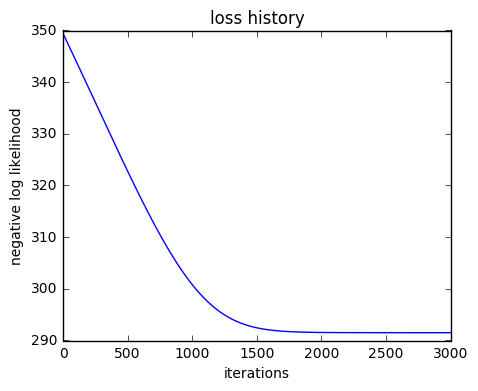

In [15]:
plt.plot(solver.loss_history)
plt.xlabel('iterations')
plt.ylabel('negative log likelihood')
plt.title('loss history')
plt.show()

In [16]:
solver = Solver(AR_model, Y,
                          update_rule='sgd_momentum',
                          optim_config={
                            'learning_rate': 1e-6,
                          },
                          
                          num_epochs=3000, batch_size=1,
                          print_every=100)
solver.train()
AR_model.params

3000
the loss is 291.512950
the loss is 291.512937
the loss is 291.512930
the loss is 291.512927
the loss is 291.512925
the loss is 291.512923
the loss is 291.512923
the loss is 291.512922
the loss is 291.512922
the loss is 291.512922
the loss is 291.512922
the loss is 291.512922
the loss is 291.512921
the loss is 291.512921
the loss is 291.512921
the loss is 291.512921
the loss is 291.512921
the loss is 291.512921
the loss is 291.512921
the loss is 291.512921
the loss is 291.512921
the loss is 291.512921
the loss is 291.512921
the loss is 291.512921
the loss is 291.512921
the loss is 291.512921
the loss is 291.512921
the loss is 291.512921
the loss is 291.512921
the loss is 291.512921


{'intercept': array([ 0.05080435]),
 'phi': array([[ 0.52957223]]),
 'sigma': array([ 1.04702261])}

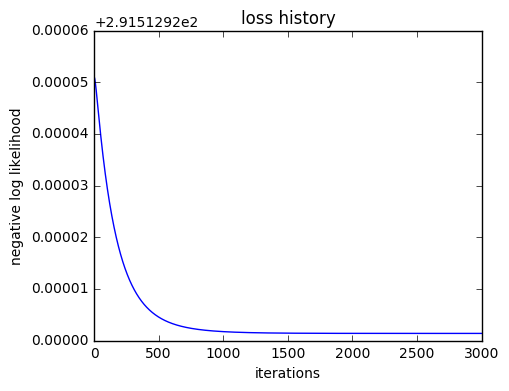

In [17]:
plt.plot(solver.loss_history)
plt.xlabel('iterations')
plt.ylabel('negative log likelihood')
plt.title('loss history')
plt.show()

In [16]:
AR_model.predict(X,10)

array([[ 0.01173585,  0.03953278,  0.05445403,  0.06246367,  0.06676321,
         0.06907117,  0.07031008,  0.07097512,  0.0713321 ,  0.07152373]])

In [8]:
from tsap.ts_gen import ar1_gen
import tsap.inference as inf

x = ar1_gen(0.5, sigma = 1, time = 200, num = 1, burnin = 2000)
X=np.array([data[0:100,0]])
Y=dp.get_return(X)

y = inf.yule_walker(x, order =1, method = "mle")
phi,sigma = inf.yule_walker(Y, order =3, method = "mle")
print phi 
print sigma



[-0.19558968 -0.04886918  0.04002632]
0.000119593894429


In [9]:

phi

array([-0.19558968, -0.04886918,  0.04002632])

In [10]:
AR_model = AR(lag=3, phi=phi, sigma=sigma, intercept=0)

In [11]:
rt=AR_model.predict(Y,10)
rt

array([[ -1.47296356e-03,  -4.76342358e-04,   5.03069047e-04,
         -1.34073966e-04,  -1.74273183e-05,   3.00966910e-05,
         -1.04014310e-05,  -1.33939402e-07,   1.73916635e-06,
         -7.49948493e-07]])

In [13]:
z=dp.get_price(X[0,99],rt)
z

array([[ 47.23232588,  47.20982712,  47.23357692,  47.22724413,
         47.22642109,  47.22784244,  47.22735121,  47.22734488,
         47.22742702,  47.2273916 ]])

In [15]:
X.shape[0]

1

In [18]:
data[100:110,0]

array([ 47.543,  46.906,  47.235,  47.235,  47.157,  46.984,  46.762,
        46.752,  46.501,  46.81 ])

In [17]:
import tsap.trading as tra
X[0,0:100].shape[0]

100

In [18]:
tra.trade(np.array([X[0,0:100]]),z,AR_model,4,4,100)

array([[ 100.       ,  100.       ,  100.0503069,  100.0503069]])